# Gradio UI

# Setup

In [2]:
!pip install -qq pytransform3d gradio opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 3.6 MB/s eta 0:00:00


In [4]:
import numpy as np
from pathlib import Path
import glob
import gradio as gr
import json
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt

In [ ]:
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

REPO_URL = "https://github.com/Tiromachelan/camera-calibration"

if in_colab():
  if not Path("camera-calibration/images").exists():
    !git clone {REPO_URL}

Cloning into 'camera-calibration'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 45 (delta 6), reused 0 (delta 0), pack-reused 27 (from 2)
Receiving objects: 100% (45/45), 70.54 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (6/6), done.


# Calibration class

In [ ]:
class Calibration:
    @staticmethod
    def calibrateCamera(image_files):
        print(f"calibrating data in folder {image_files}")
        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        pattern_size = (9, 6)
        objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d point in real world space
        imgpoints = [] # 2d points in image plane.

        images = glob.glob(image_files + '/*.jpeg')

        gray = None
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            print(f"{'processing image '}{fname}")

            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

            # If found, add object points, image points (after refining them)
            if ret == True:
                print(f"{"can find corners of "}{fname}")
                objpoints.append(objp)

                corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
                imgpoints.append(corners2)
        return(cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None))


# Gradio UI (if using images from GitHub, use "camera-calibration/images" as the path

In [ ]:
# i used the autocomplete here for like half -- EVAN
# prompts used in this cell:
#   Make this output to a json
#   Make it save the json to a file calibration.json



class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def calibrate_and_display(folder_path):
    ret, mtx, dist, rvecs, tvecs = Calibration.calibrateCamera(folder_path)

    files = glob(os.path.join(folder_path, "*.jpeg")) + glob(os.path.join(folder_path, "*.JPEG"))

    results = {
        "return_value": ret,
        "camera_matrix": mtx,
        "distortion_coefficients": dist,
        "rotation_vectors": rvecs,
        "translation_vectors": tvecs,
        "image_paths": files
    }
    json_output = json.dumps(results, cls=NumpyEncoder, indent=4)

    with open("calibration.json", "w") as f:
        f.write(json_output)

    return json_output

# Create the Gradio interface
iface = gr.Interface(
    fn=calibrate_and_display,
    inputs=gr.Textbox(label="Path to folder containing calibration images (.jpeg)"),
    outputs="json",
    title="Camera Calibration",
    description="Upload a folder containing calibration images to calibrate the camera."
)

# Launch the interface
iface.launch(debug=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86ff167cfb7f8fbc3a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Overlay and undistortion

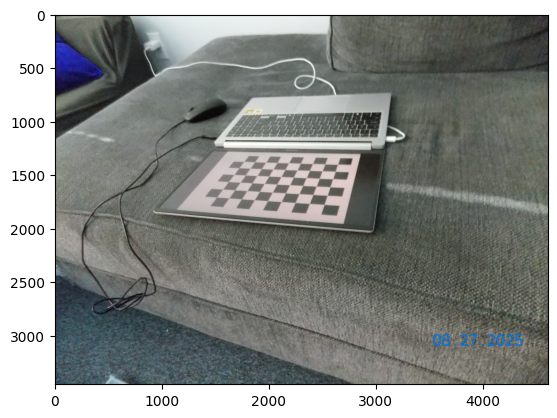

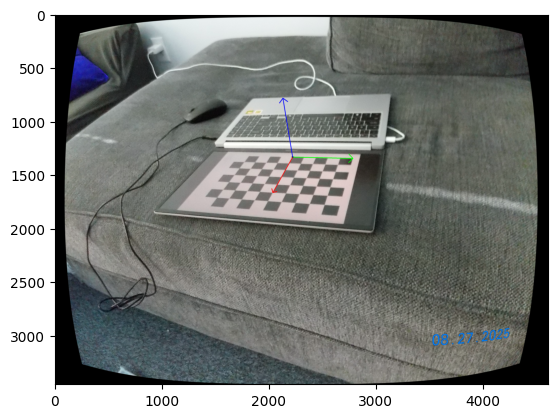

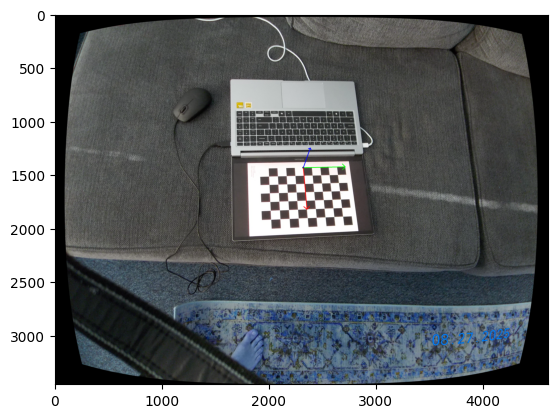

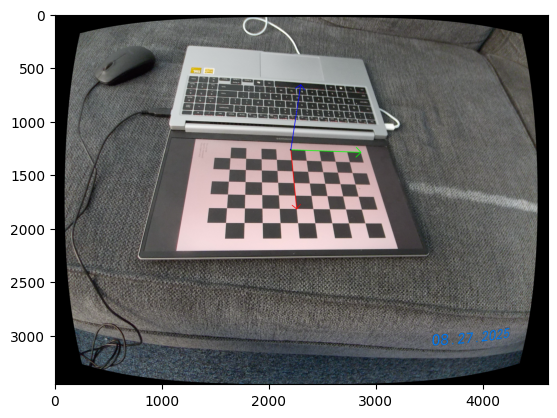

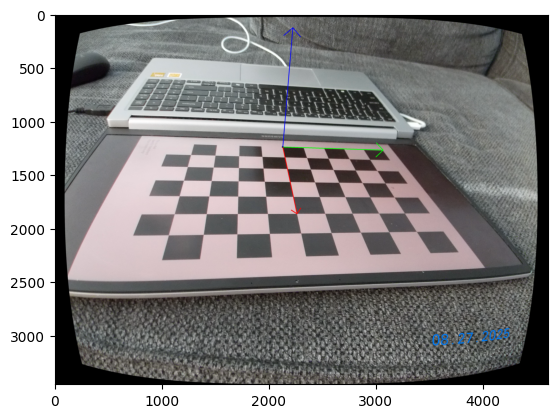

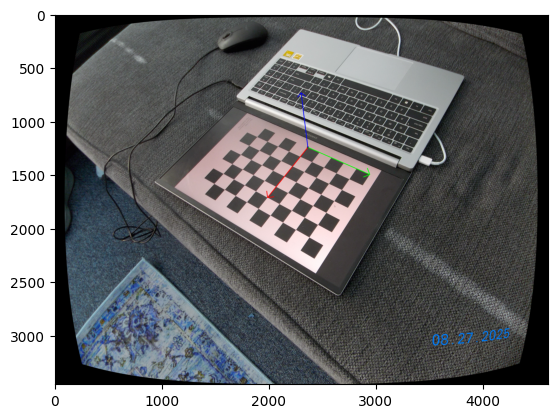

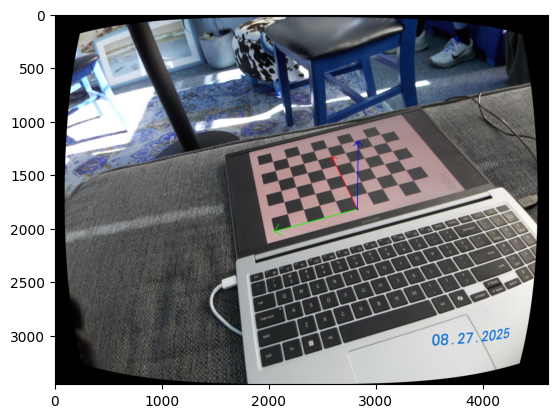

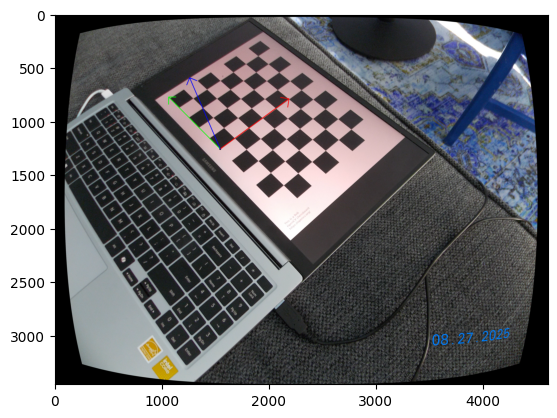

In [ ]:

class Overlay:
  def draw_coordinate_frame(image_points, img):
      x0, y0 = image_points[:,0].astype(int)
      cv2.circle(img, (x0, y0), 9, (0, 0, 0), -1)

      x1, y1 = image_points[:,1].astype(int)
      img = cv2.arrowedLine(img, (x0, y0), (x1, y1), (0, 255, 0), 5)

      x2, y2 = image_points[:,2].astype(int)
      img = cv2.arrowedLine(img, (x0, y0), (x2, y2), (255, 0, 0), 5)

      x3, y3 = image_points[:,3].astype(int)
      img = cv2.arrowedLine(img, (x0, y0), (x3, y3), (0, 0, 255), 5)


      # Display the image
      plt.imshow(img)
      plt.show()

  def plot_on_image(rvec, tvec, Lambda, dist, img):
      scale_factor = 5
      W   = scale_factor * np.array([
          [ 0, 1,  0,  0],
          [ 0, 0,  1,  0],
          [ 0, 0,  0,  1]
          ], dtype=np.float64)

      # Translate the arrows to the middle of
      W -= np.array([[4],[6],[0]], dtype=np.float64)

      rvec = np.asarray(rvec, dtype=np.float64).reshape(3,1)
      tvec = np.asarray(tvec, dtype=np.float64).reshape(3,1)

      # Project the axis points onto the image plane
      image_axes, _ = cv2.projectPoints(-W, rvec, tvec, Lambda, dist)

      # Opencv changes the format of the points.
      # Remove extra brackets from the output of cv2.projectPoints
      image_axes = image_axes.squeeze().T

      Overlay.draw_coordinate_frame(image_axes, img)

with open("calibration.json", "r") as file:
    views = json.load(file)

Lambda = np.array(views.get("camera_matrix")).reshape(3,3)
rvecs = views.get("rotation_vectors")
tvecs = views.get("translation_vectors")
dist = np.array(views.get("distortion_coefficients"))
image_paths = views.get("image_paths")

n = 0
plt.imshow(cv2.imread(image_paths[0]))
plt.show()
for rvec, tvec, image_path in zip(rvecs, tvecs, image_paths):
    img_distorted = cv2.imread(image_path)
    img = cv2.undistort(img_distorted, Lambda, dist)

    Overlay.plot_on_image(rvec, tvec, Lambda, dist, img)

    n += 1
    if n >= 7:
      break

# Camera Visualizer in 3D space

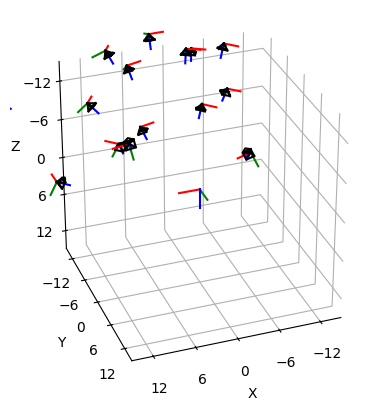

In [ ]:
class Visualizer:
  def visualize():
    sensor_size = (4608, 3456) # maybe change this in case the images are different sizes?
    virtual_image_distance = .8
    with open("calibration.json", "r") as file:
        views = json.load(file)

    Lambda = np.array(views.get("camera_matrix")).reshape(3,3)
    Omega = views.get("rotation_vectors")
    tau = views.get("translation_vectors")
    dist = np.array(views.get("distortion_coefficients"))

    for Omega_single, tau_single in zip(Omega, tau):

        # Convert to a rotation matrix from a vector to work with the existing code
        Omega, _ = cv2.Rodrigues(np.array(Omega_single))
        tau = np.array(tau_single)

        # This is the camera coordinate frame
        # Camera pose, i.e., the matrix [R t] of extrinsic parameters
        Rt = np.block([Omega.T, -Omega.T @ tau])

        # Convert Rt from 3x4 to a 4x4 transformation matrix
        Rt = np.vstack([Rt, [0, 0, 0, 1]])

        cam2world = Rt
        ax = pt.plot_transform(A2B=cam2world, s=2,
                            # name="Camera"
                            )
        pc.plot_camera(
            ax,
            cam2world=cam2world,
            M=Lambda,
            sensor_size=sensor_size,
            virtual_image_distance=virtual_image_distance,
        )

    # out of the loop
    cam2world = pt.transform_from_pq([0, 0, 0, 0, 0, 0, 0])
    #print(f"Camera to world transformation:\n{cam2world}\n")
    pt.plot_transform(ax, A2B=cam2world, s=3,
                    #name="World"
                    )


    ax.view_init(30, 70)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_zlim(-15, 15)
    ax.invert_zaxis() # It looks upside down without this


    plt.show()

Visualizer.visualize()

## Assignment 2: Estimate the pose of cameras using planar objects

In [ ]:
class calib:
  @staticmethod
  def load_calibration(jsonPath:str='calibration.json'):
    with open(jsonPath, 'r') as file:
            calibrationDict = json.load(file)
    #extracting k and distance coefficientse
    k = calibrationDict['camera_matrix']
    distanceCoeff = calibrationDict['distortion_coefficients']
    return k, distanceCoeff


{'return_value': 0.6168792517672308, 'camera_matrix': [[3036.3082856978913, 0.0, 2283.839440144747], [0.0, 3037.166446206354, 1645.1669846680163], [0.0, 0.0, 1.0]], 'distortion_coefficients': [[0.030416991360588924, -0.19095457234709834, -0.007194285903434704, -0.0004220010747058591, 0.5365693949444537]], 'rotation_vectors': [[[-0.282570706207058], [-0.8299218896994042], [-2.80542064413945]], [[-0.3524682643121777], [-0.6987916325399393], [-2.4878552019121543]], [[-0.6329886100305229], [0.7059950394805523], [1.4545838892880822]], [[-0.21459137694193486], [0.5149754164733619], [3.0375139497575963]], [[-0.35811148792375], [-1.327934623228151], [-2.6212925730821923]], [[-0.24521384882583744], [1.4268353473432518], [2.70497219893632]], [[-0.35469632907598714], [0.9428130952687862], [2.066887362618932]], [[-0.7712819041133753], [0.027424002266368666], [-0.2697394913310298]], [[-0.34927060118108016], [0.9381067122048488], [2.348918856159363]], [[-0.46936152349990073], [-0.8914567432208498], 

In [1]:
class Model:
  @staticmethod
  def load_points(csv_path:str):
    points = np.loadtxt(csv_path)
    return points